In [1]:
# from analyse_model import main as test
# test()
from tensor2tensor.visualization import attention
import h5py
import numpy as np
from sample_latent import visualize_latent_rep
from molecules.model import Transformer
from dataloader import pad_smiles, attn_params, MakeSmilesDict, MakeSmilesData
from keras.optimizers import Adam


model_dir = 'models/VA_292_512_3/'

# Load in model
model_params = attn_params()
model_params.load(model_dir + "params.pkl")

# Prepare model
d_file = model_params.get("d_file")
tokens = MakeSmilesDict(d_file, dict_file=d_file.replace('.txt', '_dict.txt'))
model = Transformer(tokens, model_params)
model.compile_vae(Adam(0.001, 0.9, 0.98, epsilon=1e-9))
model.autoencoder.load_weights(model_dir + "best_model.h5")

Using TensorFlow backend.


Loading preprocessed dictionary file data/zinc_100k_dict.txt


In [8]:
smiles_str = 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'
smiles_seq = pad_smiles(smiles_str, tokens=tokens, max_len=model_params.get("len_limit"))
attentions = model.output_attns.predict_on_batch([smiles_seq, smiles_seq])

In [13]:
n_layers = int(len(attentions) / 3)
# reshape_attn = lambda ATT : np.swapaxes(np.expand_dims(np.array(ATT),1), 3, 4)
reshape_attn = lambda ATT : np.expand_dims(np.array(ATT),1)
enc_atts = reshape_attn(attentions[0:n_layers])
dec_atts = reshape_attn(attentions[n_layers:2*n_layers])
# dec_atts = np.expand_dims(dec_atts[:,:,:,1,:],3)

encdec_atts = reshape_attn(attentions[2 * n_layers:])
# encdec_atts = np.expand_dims(encdec_atts[:,:,:,1,:],3)

print("Shapes of arrays:\n\tenc_atts:\t{}\n\tdec_atts:\t{}\n\tencdec_atts:\t{}".format(np.shape(enc_atts), np.shape(dec_atts), np.shape(encdec_atts)))

Shapes of arrays:
	enc_atts:	(3, 1, 8, 31, 31)
	dec_atts:	(3, 1, 8, 30, 30)
	encdec_atts:	(3, 1, 8, 30, 31)


In [14]:
out_str = list(smiles_str) + [tokens.token(tokens.endid())]
in_str = [tokens.token(tokens.startid())] + out_str
# print(in_str)
# in_str = [u"a" for s in in_str]
# print(in_str)
# out_str = [u"b" for s in out_str]
from analyse_model import call_html
call_html()
attention.show(in_str, out_str, enc_atts, dec_atts, encdec_atts)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

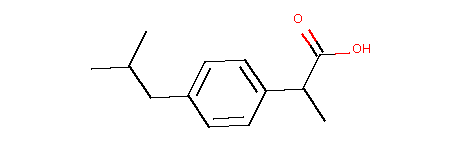

In [21]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=2.8
ibu = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
ibu
# from rdkit.Chem import AllChem
# ibuH = AllChem.AddHs(ibu)
# ibuH